# TRABAJO PRÁCTICO PYSPARK
MAESTRIA EN CIENCIA DE DATOS

Universidad Icesi


INTEGRANTES
- Andres Candelo
- Victor Cardona
- Laura  Loaiza
- Mauricio Gutierrez

Los pasos que se desarrollaron para este trabajo fueron los siguientes:

•	Entendimiento de las variables.

•	Análisis exploratorio para cada una de las variables del dataset, que son características dentro de un partido de la NBA. El dataset abarca un periodo desde 1923.

•	Filtrado de los datos históricos del equipo Boston Celtics de la NBA, mostrando todos los partidos que este equipo ha tenido con los demás equipos.

•	Predicción de si el equipo va a ganar o perder. Para esto, se realizó un preprocesamiento de datos que implicó:

•	Cálculo del promedio móvil de los primeros 5 partidos0.

•	Creación de un registro que contiene el promedio de los últimos 5 partidos y el resultado del partido.

• Se realizó  la division del dataset en train, test y val con el fin de probar el modelo con datos que el modelo nunca ha visto.

•	Aplicación de one-hot encoding para incluir el partido contra el oponente en el modelo.

Después de los pasos mencionados, se procedió a entrenar tres modelos de clasificación, los cuales fueron:
  •	Random Forest

  •	Regresión Logística

  •	Support Vector Machine

Además, se realizó la optimización de hiperparámetros para cada uno de estos modelos con el fin de mejorar su rendimiento y precisión en la predicción.

In [1]:
!pip install pyspark_dist_explore

In [2]:
!pip install pyspark

In [3]:
# Instalar findspark para configurar PySpark en Google Colab
!pip install findspark

- Objetivo

Predecir si el equipo Boston Celtics de la NBA gana o pierde basado en el desempeño historico que ha tenido en partidos anteriores.

- Contexto

Para obtener los datos nos vamos a conectar al API de la NBA
https://github.com/swar/nba_api?tab=readme-ov-file

In [4]:
pip install nba_api

In [5]:
from nba_api.stats.static import teams
from pyspark.sql import SparkSession
# Iniciar una sesión de Spark
spark = SparkSession.builder \
    .appName("GetTeamID") \
    .getOrCreate()

# Obtener los equipos de la NBA usando SparkSession
nba_teams = teams.get_teams()

# Crear un DataFrame a partir de la lista de equipos
df_nba_teams = spark.createDataFrame(nba_teams)

# Filtrar el equipo de los Celtics
celtics = df_nba_teams.filter(df_nba_teams.abbreviation == 'BOS').collect()[0]

# Obtener el ID de los Celtics
celtics_id = celtics['id']

# Imprimir el ID de los Celtics
print("ID de los Celtics:", celtics_id)

ID de los Celtics: 1610612738


In [6]:
from nba_api.stats.endpoints import leaguegamefinder

# Iniciar una sesión de Spark
spark = SparkSession.builder \
    .appName("GetCelticsGames") \
    .getOrCreate()

# Query para buscar los juegos donde los Celtics estaban jugando
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=celtics_id)

# Obtener el DataFrame de los juegos
df = spark.createDataFrame(gamefinder.get_data_frames()[0])

In [7]:
df.show()

+---------+----------+-----------------+--------------+----------+----------+-----------+---+---+---+---+---+------+----+----+-------+---+---+------+----+----+---+---+---+---+---+---+----------+
|SEASON_ID|   TEAM_ID|TEAM_ABBREVIATION|     TEAM_NAME|   GAME_ID| GAME_DATE|    MATCHUP| WL|MIN|PTS|FGM|FGA|FG_PCT|FG3M|FG3A|FG3_PCT|FTM|FTA|FT_PCT|OREB|DREB|REB|AST|STL|BLK|TOV| PF|PLUS_MINUS|
+---------+----------+-----------------+--------------+----------+----------+-----------+---+---+---+---+---+------+----+----+-------+---+---+------+----+----+---+---+---+---+---+---+----------+
|    22023|1610612738|              BOS|Boston Celtics|0022300955|2024-03-14|BOS vs. PHX|  W|240|127| 47| 89| 0.528|  25|  50|    0.5|  8| 11| 0.727|   6|  27| 33| 31| 12|  5|  8| 13|      15.0|
|    22023|1610612738|              BOS|Boston Celtics|0022300943|2024-03-12|  BOS @ UTA|  W|241|123| 43| 92| 0.467|  20|  49|  0.408| 17| 19| 0.895|  14|  32| 46| 25|  5|  8|  8| 14|      16.0|
|    22023|1610612738|   

### Limpieza y análisis de los datos

In [8]:
# Contar filas
num_rows = df.count()

# Contar columnas
num_columns = len(df.columns)

print("Número de filas:", num_rows)
print("Número de columnas:", num_columns)


Número de filas: 3877
Número de columnas: 28


Renombramos las variables

In [9]:
df = df \
    .withColumnRenamed("SEASON_ID", "ID_Temporada") \
    .withColumnRenamed("TEAM_ID", "ID_Equipo") \
    .withColumnRenamed("TEAM_ABBREVIATION", "Abreviatura_Equipo") \
    .withColumnRenamed("TEAM_NAME", "Nombre_Equipo") \
    .withColumnRenamed("GAME_ID", "ID_Juego") \
    .withColumnRenamed("GAME_DATE", "Fecha_Juego") \
    .withColumnRenamed("MATCHUP", "Encuentro") \
    .withColumnRenamed("WL", "Resultado") \
    .withColumnRenamed("MIN", "Minutos") \
    .withColumnRenamed("PTS", "Puntos") \
    .withColumnRenamed("FGM", "Tiros_Campo_Anotados") \
    .withColumnRenamed("FGA", "Tiros_Campo_Intentados") \
    .withColumnRenamed("FG_PCT", "Porcentaje_Tiros_Campo") \
    .withColumnRenamed("FG3M", "Triples_Anotados") \
    .withColumnRenamed("FG3A", "Triples_Intentados") \
    .withColumnRenamed("FG3_PCT", "Porcentaje_Triples") \
    .withColumnRenamed("FTM", "Tiros_Libres_Anotados") \
    .withColumnRenamed("FTA", "Tiros_Libres_Intentados") \
    .withColumnRenamed("FT_PCT", "Porcentaje_Tiros_Libres") \
    .withColumnRenamed("OREB", "Rebotes_Ofensivos") \
    .withColumnRenamed("DREB", "Rebotes_Defensivos") \
    .withColumnRenamed("REB", "Total_Rebotes") \
    .withColumnRenamed("AST", "Asistencias") \
    .withColumnRenamed("STL", "Robos") \
    .withColumnRenamed("BLK", "Bloqueos") \
    .withColumnRenamed("TOV", "Pérdidas") \
    .withColumnRenamed("PF", "Faltas_Personales") \
    .withColumnRenamed("PLUS_MINUS", "Más_Menos")

In [10]:
# Mostrar el DataFrame resultante
df.show()

+------------+----------+------------------+--------------+----------+-----------+-----------+---------+-------+------+--------------------+----------------------+----------------------+----------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------+------------------+-------------+-----------+-----+--------+--------+-----------------+---------+
|ID_Temporada| ID_Equipo|Abreviatura_Equipo| Nombre_Equipo|  ID_Juego|Fecha_Juego|  Encuentro|Resultado|Minutos|Puntos|Tiros_Campo_Anotados|Tiros_Campo_Intentados|Porcentaje_Tiros_Campo|Triples_Anotados|Triples_Intentados|Porcentaje_Triples|Tiros_Libres_Anotados|Tiros_Libres_Intentados|Porcentaje_Tiros_Libres|Rebotes_Ofensivos|Rebotes_Defensivos|Total_Rebotes|Asistencias|Robos|Bloqueos|Pérdidas|Faltas_Personales|Más_Menos|
+------------+----------+------------------+--------------+----------+-----------+-----------+---------+-------+------+--------------------+------

Vamos a eliminar columnas que consideramos no significativas para  el ejercicio

In [11]:
variables_a_eliminar = ['ID_Temporada',  'ID_Equipo',  'Abreviatura_Equipo', 'Nombre_Equipo', 'ID_Juego', ]

# Eliminar las variables especificadas
df = df.drop(*variables_a_eliminar)

In [12]:
from pyspark.sql.functions import substring
## Renombramos variable encuentro
df = df.withColumn("Encuentro", substring(df["Encuentro"], -3, 3))

In [13]:
df.show()

+-----------+---------+---------+-------+------+--------------------+----------------------+----------------------+----------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------+------------------+-------------+-----------+-----+--------+--------+-----------------+---------+
|Fecha_Juego|Encuentro|Resultado|Minutos|Puntos|Tiros_Campo_Anotados|Tiros_Campo_Intentados|Porcentaje_Tiros_Campo|Triples_Anotados|Triples_Intentados|Porcentaje_Triples|Tiros_Libres_Anotados|Tiros_Libres_Intentados|Porcentaje_Tiros_Libres|Rebotes_Ofensivos|Rebotes_Defensivos|Total_Rebotes|Asistencias|Robos|Bloqueos|Pérdidas|Faltas_Personales|Más_Menos|
+-----------+---------+---------+-------+------+--------------------+----------------------+----------------------+----------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------+------------------+-----------

In [14]:
df.describe().show()

+-------+-----------+---------+---------+------------------+------------------+--------------------+----------------------+----------------------+-----------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------+
|summary|Fecha_Juego|Encuentro|Resultado|           Minutos|            Puntos|Tiros_Campo_Anotados|Tiros_Campo_Intentados|Porcentaje_Tiros_Campo| Triples_Anotados|Triples_Intentados|Porcentaje_Triples|Tiros_Libres_Anotados|Tiros_Libres_Intentados|Porcentaje_Tiros_Libres|Rebotes_Ofensivos|Rebotes_Defensivos|     Total_Rebotes|       Asistencias|             Robos|          Bloqueos|          Pérdidas| Faltas_Personales|Más_Menos|
+-------+-----------+---------+---------+------------------+------------------+--------------------+----------------------+---------

Conclusiones
 -El dataset contiene registros de partidos desde 1983-10-28 hasta 2024-03-14, es decir 41 años de registros

 - En estos 41 años el equipo Boston Celtics tiene una efectividad de tiros del 46.64%

 - En estos 41 años el equipo Boston Celtics anota en promedio 6.5 puntos triples por partido

 - En estos 41 años el equipo Boston Celtics anota en promedio 19.15 tiros libres

 - Varias columnas contienen valores NaN, analizaremos esto a continuacion



In [15]:
from pyspark.sql import functions as F

conteo_nulos_por_columna = df.select([F.sum(F.col(column).isNull().cast("int")).alias(column) for column in df.columns])

# Mostrar el conteo de nulos por columna
conteo_nulos_por_columna.show()

+-----------+---------+---------+-------+------+--------------------+----------------------+----------------------+----------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------+------------------+-------------+-----------+-----+--------+--------+-----------------+---------+
|Fecha_Juego|Encuentro|Resultado|Minutos|Puntos|Tiros_Campo_Anotados|Tiros_Campo_Intentados|Porcentaje_Tiros_Campo|Triples_Anotados|Triples_Intentados|Porcentaje_Triples|Tiros_Libres_Anotados|Tiros_Libres_Intentados|Porcentaje_Tiros_Libres|Rebotes_Ofensivos|Rebotes_Defensivos|Total_Rebotes|Asistencias|Robos|Bloqueos|Pérdidas|Faltas_Personales|Más_Menos|
+-----------+---------+---------+-------+------+--------------------+----------------------+----------------------+----------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------+------------------+-----------

In [16]:
## Observamos que existe un valor nulo en el partido del 2007, se toma la decision de eliminar la fila
df.filter(F.col('Resultado').isNull()).show()

+-----------+---------+---------+-------+------+--------------------+----------------------+----------------------+----------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------+------------------+-------------+-----------+-----+--------+--------+-----------------+---------+
|Fecha_Juego|Encuentro|Resultado|Minutos|Puntos|Tiros_Campo_Anotados|Tiros_Campo_Intentados|Porcentaje_Tiros_Campo|Triples_Anotados|Triples_Intentados|Porcentaje_Triples|Tiros_Libres_Anotados|Tiros_Libres_Intentados|Porcentaje_Tiros_Libres|Rebotes_Ofensivos|Rebotes_Defensivos|Total_Rebotes|Asistencias|Robos|Bloqueos|Pérdidas|Faltas_Personales|Más_Menos|
+-----------+---------+---------+-------+------+--------------------+----------------------+----------------------+----------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------+------------------+-----------

In [17]:
df = df.filter(F.col('Resultado').isNotNull())

In [18]:
from pyspark.sql.functions import count
encuentros_por_tipo = df.groupBy("Resultado").agg(count("*").alias("Total_Encuentros"))

# Mostrar los resultados
encuentros_por_tipo.show()

+---------+----------------+
|Resultado|Total_Encuentros|
+---------+----------------+
|        L|            1685|
|        W|            2190|
|         |               1|
+---------+----------------+



In [19]:
## Vemos que existe un valor sin registro para un partido del 2019, tambien se decide eliminar este registro
df.filter(F.col('Resultado') == " ").show()

+-----------+---------+---------+-------+------+--------------------+----------------------+----------------------+----------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------+------------------+-------------+-----------+-----+--------+--------+-----------------+---------+
|Fecha_Juego|Encuentro|Resultado|Minutos|Puntos|Tiros_Campo_Anotados|Tiros_Campo_Intentados|Porcentaje_Tiros_Campo|Triples_Anotados|Triples_Intentados|Porcentaje_Triples|Tiros_Libres_Anotados|Tiros_Libres_Intentados|Porcentaje_Tiros_Libres|Rebotes_Ofensivos|Rebotes_Defensivos|Total_Rebotes|Asistencias|Robos|Bloqueos|Pérdidas|Faltas_Personales|Más_Menos|
+-----------+---------+---------+-------+------+--------------------+----------------------+----------------------+----------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------+------------------+-----------

In [20]:
# Eliminar la fila donde 'Resultado' es vacío
df = df.filter(F.col('Resultado') != " ")

In [21]:
# Calcular el total de encuentros
total_encuentros = df.count()

# Calcular los encuentros por tipo de resultado
encuentros_por_tipo = df.groupBy("Resultado").count().withColumnRenamed("count", "Total_Encuentros")

# Calcular el porcentaje
encuentros_por_tipo = encuentros_por_tipo.withColumn("Porcentaje", (F.col("Total_Encuentros") / total_encuentros) * 100)

# Mostrar los resultados
encuentros_por_tipo.show()


+---------+----------------+------------------+
|Resultado|Total_Encuentros|        Porcentaje|
+---------+----------------+------------------+
|        L|            1685|43.483870967741936|
|        W|            2190|56.516129032258064|
+---------+----------------+------------------+



vemos que la variable objetivo esta balanceada

In [22]:
# Crear un diccionario para almacenar los porcentajes de NaN por columna
porcentaje_nan_por_columna = {}

# Obtener el número total de filas en el DataFrame
total_filas = df.count()

# Iterar sobre cada columna del DataFrame
for columna in df.columns:
    # Contar la cantidad de valores NaN en la columna actual
    cantidad_nan = df.where(F.isnan(F.col(columna))).count()
    # Calcular el porcentaje de NaN en relación con el total de filas
    porcentaje_nan = (cantidad_nan / total_filas) * 100
    # Agregar el porcentaje al diccionario
    porcentaje_nan_por_columna[columna] = porcentaje_nan

# Mostrar el porcentaje de NaN por columna
for columna, porcentaje in porcentaje_nan_por_columna.items():
    print(f"Porcentaje de NaN en columna '{columna}': {porcentaje:.2f}%")

Porcentaje de NaN en columna 'Fecha_Juego': 0.00%
Porcentaje de NaN en columna 'Encuentro': 0.00%
Porcentaje de NaN en columna 'Resultado': 0.00%
Porcentaje de NaN en columna 'Minutos': 0.00%
Porcentaje de NaN en columna 'Puntos': 0.00%
Porcentaje de NaN en columna 'Tiros_Campo_Anotados': 0.00%
Porcentaje de NaN en columna 'Tiros_Campo_Intentados': 0.00%
Porcentaje de NaN en columna 'Porcentaje_Tiros_Campo': 0.00%
Porcentaje de NaN en columna 'Triples_Anotados': 0.00%
Porcentaje de NaN en columna 'Triples_Intentados': 0.00%
Porcentaje de NaN en columna 'Porcentaje_Triples': 0.90%
Porcentaje de NaN en columna 'Tiros_Libres_Anotados': 0.00%
Porcentaje de NaN en columna 'Tiros_Libres_Intentados': 0.00%
Porcentaje de NaN en columna 'Porcentaje_Tiros_Libres': 0.00%
Porcentaje de NaN en columna 'Rebotes_Ofensivos': 0.00%
Porcentaje de NaN en columna 'Rebotes_Defensivos': 0.00%
Porcentaje de NaN en columna 'Total_Rebotes': 0.00%
Porcentaje de NaN en columna 'Asistencias': 0.00%
Porcentaje de 

Observamos que hay valores NaN en las columnas Porcentaje_Triples y Más_Menos, estos se imputaran mas adelante

In [23]:
# Ordenar el DataFrame de menor a mayor por la columna 'Fecha_Juego'
#df = df.orderBy(F.col('Fecha_Juego'))
#df = df.drop('Fecha_Juego')
# Mostrar el DataFrame ordenado
df.show()

+-----------+---------+---------+-------+------+--------------------+----------------------+----------------------+----------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------+------------------+-------------+-----------+-----+--------+--------+-----------------+---------+
|Fecha_Juego|Encuentro|Resultado|Minutos|Puntos|Tiros_Campo_Anotados|Tiros_Campo_Intentados|Porcentaje_Tiros_Campo|Triples_Anotados|Triples_Intentados|Porcentaje_Triples|Tiros_Libres_Anotados|Tiros_Libres_Intentados|Porcentaje_Tiros_Libres|Rebotes_Ofensivos|Rebotes_Defensivos|Total_Rebotes|Asistencias|Robos|Bloqueos|Pérdidas|Faltas_Personales|Más_Menos|
+-----------+---------+---------+-------+------+--------------------+----------------------+----------------------+----------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------+------------------+-----------

### Estadisticas descriptivas

In [24]:
Más_Menos=df.select('Más_Menos').toPandas()

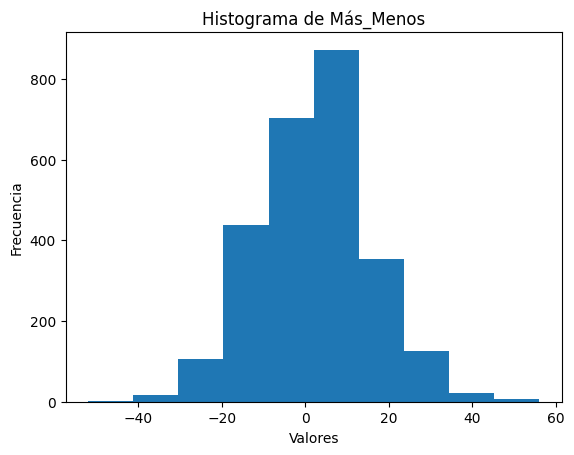

In [25]:
import matplotlib.pyplot as plt

# Suponiendo que 'Más_Menos' es una lista o array de datos
plt.hist(Más_Menos)
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma de Más_Menos')
plt.show()

Cambiar tipo de dato:

In [26]:
columns_to_convert = ['Minutos', 'Puntos', 'Tiros_Campo_Anotados', 'Tiros_Campo_Intentados',
                      'Triples_Anotados', 'Triples_Intentados', 'Tiros_Libres_Anotados',
                      'Tiros_Libres_Intentados', 'Rebotes_Ofensivos', 'Rebotes_Defensivos',
                      'Total_Rebotes', 'Asistencias', 'Robos', 'Bloqueos', 'Pérdidas',
                      'Faltas_Personales', 'Más_Menos']

for col_name in columns_to_convert:
    df = df.withColumn(col_name, F.col(col_name).cast('int'))

In [27]:
columns_to_convert = ['Porcentaje_Tiros_Campo', 'Porcentaje_Triples', 'Porcentaje_Tiros_Libres']

for col_name in columns_to_convert:
    df = df.withColumn(col_name, F.col(col_name).cast('float'))

In [28]:
df.printSchema()

root
 |-- Fecha_Juego: string (nullable = true)
 |-- Encuentro: string (nullable = true)
 |-- Resultado: string (nullable = true)
 |-- Minutos: integer (nullable = true)
 |-- Puntos: integer (nullable = true)
 |-- Tiros_Campo_Anotados: integer (nullable = true)
 |-- Tiros_Campo_Intentados: integer (nullable = true)
 |-- Porcentaje_Tiros_Campo: float (nullable = true)
 |-- Triples_Anotados: integer (nullable = true)
 |-- Triples_Intentados: integer (nullable = true)
 |-- Porcentaje_Triples: float (nullable = true)
 |-- Tiros_Libres_Anotados: integer (nullable = true)
 |-- Tiros_Libres_Intentados: integer (nullable = true)
 |-- Porcentaje_Tiros_Libres: float (nullable = true)
 |-- Rebotes_Ofensivos: integer (nullable = true)
 |-- Rebotes_Defensivos: integer (nullable = true)
 |-- Total_Rebotes: integer (nullable = true)
 |-- Asistencias: integer (nullable = true)
 |-- Robos: integer (nullable = true)
 |-- Bloqueos: integer (nullable = true)
 |-- Pérdidas: integer (nullable = true)
 |-- F

In [29]:
df.select('Porcentaje_Triples').distinct().show()

+------------------+
|Porcentaje_Triples|
+------------------+
|             0.279|
|             0.474|
|             0.115|
|              0.34|
|              0.42|
|             0.455|
|             0.407|
|              0.15|
|             0.432|
|             0.481|
|             0.447|
|             0.611|
|             0.688|
|              0.38|
|             0.444|
|             0.344|
|             0.237|
|             0.345|
|             0.176|
|             0.632|
+------------------+
only showing top 20 rows



In [30]:

df.select('Porcentaje_Triples').describe().show()

+-------+------------------+
|summary|Porcentaje_Triples|
+-------+------------------+
|  count|              3875|
|   mean|               NaN|
| stddev|               NaN|
|    min|               0.0|
|    max|               NaN|
+-------+------------------+



In [31]:
from pyspark.sql import functions as F

# Obtener las columnas numéricas
columnas_numericas = [c for c, t in df.dtypes if t in ('double', 'float')]

# Calcular las medias de cada columna numérica
means = df.select([F.mean(c).alias(c) for c in columnas_numericas]).first().asDict()

# Reemplazar los valores NaN con la media de cada columna
for col_name, mean_value in means.items():
    df = df.fillna({col_name: mean_value})

In [32]:
means

{'Porcentaje_Tiros_Campo': 0.46651535496404095,
 'Porcentaje_Triples': nan,
 'Porcentaje_Tiros_Libres': 0.7745295483143099}

In [33]:
# Crear un diccionario para almacenar los porcentajes de NaN por columna
porcentaje_nan_por_columna = {}

# Obtener el número total de filas en el DataFrame
total_filas = df.count()

# Iterar sobre cada columna del DataFrame
for columna in df.columns:
    # Contar la cantidad de valores NaN en la columna actual
    cantidad_nan = df.where(F.isnan(F.col(columna))).count()
    # Calcular el porcentaje de NaN en relación con el total de filas
    porcentaje_nan = (cantidad_nan / total_filas) * 100
    # Agregar el porcentaje al diccionario
    porcentaje_nan_por_columna[columna] = porcentaje_nan

# Mostrar el porcentaje de NaN por columna
for columna, porcentaje in porcentaje_nan_por_columna.items():
    print(f"Porcentaje de NaN en columna '{columna}': {porcentaje:.2f}%")

Porcentaje de NaN en columna 'Fecha_Juego': 0.00%
Porcentaje de NaN en columna 'Encuentro': 0.00%
Porcentaje de NaN en columna 'Resultado': 0.00%
Porcentaje de NaN en columna 'Minutos': 0.00%
Porcentaje de NaN en columna 'Puntos': 0.00%
Porcentaje de NaN en columna 'Tiros_Campo_Anotados': 0.00%
Porcentaje de NaN en columna 'Tiros_Campo_Intentados': 0.00%
Porcentaje de NaN en columna 'Porcentaje_Tiros_Campo': 0.00%
Porcentaje de NaN en columna 'Triples_Anotados': 0.00%
Porcentaje de NaN en columna 'Triples_Intentados': 0.00%
Porcentaje de NaN en columna 'Porcentaje_Triples': 0.90%
Porcentaje de NaN en columna 'Tiros_Libres_Anotados': 0.00%
Porcentaje de NaN en columna 'Tiros_Libres_Intentados': 0.00%
Porcentaje de NaN en columna 'Porcentaje_Tiros_Libres': 0.00%
Porcentaje de NaN en columna 'Rebotes_Ofensivos': 0.00%
Porcentaje de NaN en columna 'Rebotes_Defensivos': 0.00%
Porcentaje de NaN en columna 'Total_Rebotes': 0.00%
Porcentaje de NaN en columna 'Asistencias': 0.00%
Porcentaje de 

In [34]:
df.count()

3875

In [35]:
df = df.filter(~F.isnan('Porcentaje_Triples'))

In [36]:
df.count()

3840

In [37]:
# Crear un diccionario para almacenar los porcentajes de NaN por columna
porcentaje_nan_por_columna = {}

# Obtener el número total de filas en el DataFrame
total_filas = df.count()

# Iterar sobre cada columna del DataFrame
for columna in df.columns:
    # Contar la cantidad de valores NaN en la columna actual
    cantidad_nan = df.where(F.isnan(F.col(columna))).count()
    # Calcular el porcentaje de NaN en relación con el total de filas
    porcentaje_nan = (cantidad_nan / total_filas) * 100
    # Agregar el porcentaje al diccionario
    porcentaje_nan_por_columna[columna] = porcentaje_nan

# Mostrar el porcentaje de NaN por columna
for columna, porcentaje in porcentaje_nan_por_columna.items():
    print(f"Porcentaje de NaN en columna '{columna}': {porcentaje:.2f}%")

Porcentaje de NaN en columna 'Fecha_Juego': 0.00%
Porcentaje de NaN en columna 'Encuentro': 0.00%
Porcentaje de NaN en columna 'Resultado': 0.00%
Porcentaje de NaN en columna 'Minutos': 0.00%
Porcentaje de NaN en columna 'Puntos': 0.00%
Porcentaje de NaN en columna 'Tiros_Campo_Anotados': 0.00%
Porcentaje de NaN en columna 'Tiros_Campo_Intentados': 0.00%
Porcentaje de NaN en columna 'Porcentaje_Tiros_Campo': 0.00%
Porcentaje de NaN en columna 'Triples_Anotados': 0.00%
Porcentaje de NaN en columna 'Triples_Intentados': 0.00%
Porcentaje de NaN en columna 'Porcentaje_Triples': 0.00%
Porcentaje de NaN en columna 'Tiros_Libres_Anotados': 0.00%
Porcentaje de NaN en columna 'Tiros_Libres_Intentados': 0.00%
Porcentaje de NaN en columna 'Porcentaje_Tiros_Libres': 0.00%
Porcentaje de NaN en columna 'Rebotes_Ofensivos': 0.00%
Porcentaje de NaN en columna 'Rebotes_Defensivos': 0.00%
Porcentaje de NaN en columna 'Total_Rebotes': 0.00%
Porcentaje de NaN en columna 'Asistencias': 0.00%
Porcentaje de 

In [38]:
dataset=df
dataset1=df

In [39]:
df=dataset

In [40]:
from pyspark.sql.functions import to_date
df = df.withColumn("Fecha_Juego", to_date(df["Fecha_Juego"], "yyyy-MM-dd"))


In [41]:
df.show()

+-----------+---------+---------+-------+------+--------------------+----------------------+----------------------+----------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------+------------------+-------------+-----------+-----+--------+--------+-----------------+---------+
|Fecha_Juego|Encuentro|Resultado|Minutos|Puntos|Tiros_Campo_Anotados|Tiros_Campo_Intentados|Porcentaje_Tiros_Campo|Triples_Anotados|Triples_Intentados|Porcentaje_Triples|Tiros_Libres_Anotados|Tiros_Libres_Intentados|Porcentaje_Tiros_Libres|Rebotes_Ofensivos|Rebotes_Defensivos|Total_Rebotes|Asistencias|Robos|Bloqueos|Pérdidas|Faltas_Personales|Más_Menos|
+-----------+---------+---------+-------+------+--------------------+----------------------+----------------------+----------------+------------------+------------------+---------------------+-----------------------+-----------------------+-----------------+------------------+-----------

In [42]:
# Ordenar por Fecha_Juego
from pyspark.sql.window import Window
df = df.orderBy("Fecha_Juego")

# Definir la ventana para calcular el promedio móvil
windowSpec = Window.orderBy("Fecha_Juego").rowsBetween(-5, -1)

# Calcular el promedio móvil para cada columna numérica y eliminar las columnas originales
for col_name, col_type in df.dtypes:
    if col_type in ['int', 'float']:
        df = df.withColumn(col_name + "_prom_movil", F.avg(col_name).over(windowSpec))
        df = df.drop(col_name)

# Mostrar el DataFrame resultante
df.show()

+-----------+---------+---------+------------------+------------------+-------------------------------+---------------------------------+---------------------------------+---------------------------+-----------------------------+-----------------------------+--------------------------------+----------------------------------+----------------------------------+----------------------------+-----------------------------+------------------------+----------------------+-----------------+-------------------+-------------------+----------------------------+--------------------+
|Fecha_Juego|Encuentro|Resultado|Minutos_prom_movil| Puntos_prom_movil|Tiros_Campo_Anotados_prom_movil|Tiros_Campo_Intentados_prom_movil|Porcentaje_Tiros_Campo_prom_movil|Triples_Anotados_prom_movil|Triples_Intentados_prom_movil|Porcentaje_Triples_prom_movil|Tiros_Libres_Anotados_prom_movil|Tiros_Libres_Intentados_prom_movil|Porcentaje_Tiros_Libres_prom_movil|Rebotes_Ofensivos_prom_movil|Rebotes_Defensivos_prom_movil|T

In [43]:
df = df.orderBy("Fecha_Juego")

# Definir la ventana para calcular el promedio móvil
windowSpec = Window.orderBy("Fecha_Juego").rowsBetween(-5, -1)

# Calcular el promedio móvil para cada columna numérica y eliminar las columnas originales
for col_name, col_type in df.dtypes:
    if col_type in ['int', 'float']:
        df = df.withColumn(col_name + "_prom_movil", F.avg(col_name).over(windowSpec))
        df = df.drop(col_name)

# Mostrar el DataFrame resultante
df.show()

+-----------+---------+---------+------------------+------------------+-------------------------------+---------------------------------+---------------------------------+---------------------------+-----------------------------+-----------------------------+--------------------------------+----------------------------------+----------------------------------+----------------------------+-----------------------------+------------------------+----------------------+-----------------+-------------------+-------------------+----------------------------+--------------------+
|Fecha_Juego|Encuentro|Resultado|Minutos_prom_movil| Puntos_prom_movil|Tiros_Campo_Anotados_prom_movil|Tiros_Campo_Intentados_prom_movil|Porcentaje_Tiros_Campo_prom_movil|Triples_Anotados_prom_movil|Triples_Intentados_prom_movil|Porcentaje_Triples_prom_movil|Tiros_Libres_Anotados_prom_movil|Tiros_Libres_Intentados_prom_movil|Porcentaje_Tiros_Libres_prom_movil|Rebotes_Ofensivos_prom_movil|Rebotes_Defensivos_prom_movil|T

In [44]:
df

DataFrame[Fecha_Juego: date, Encuentro: string, Resultado: string, Minutos_prom_movil: double, Puntos_prom_movil: double, Tiros_Campo_Anotados_prom_movil: double, Tiros_Campo_Intentados_prom_movil: double, Porcentaje_Tiros_Campo_prom_movil: double, Triples_Anotados_prom_movil: double, Triples_Intentados_prom_movil: double, Porcentaje_Triples_prom_movil: double, Tiros_Libres_Anotados_prom_movil: double, Tiros_Libres_Intentados_prom_movil: double, Porcentaje_Tiros_Libres_prom_movil: double, Rebotes_Ofensivos_prom_movil: double, Rebotes_Defensivos_prom_movil: double, Total_Rebotes_prom_movil: double, Asistencias_prom_movil: double, Robos_prom_movil: double, Bloqueos_prom_movil: double, Pérdidas_prom_movil: double, Faltas_Personales_prom_movil: double, Más_Menos_prom_movil: double]

In [45]:
df.count()

3840

In [46]:
dataset.count()

3840

In [47]:
# Filtrar el DataFrame para incluir solo las filas con Fecha_Juego mayores o iguales a '1983-11-09'
df = df.filter(F.col("Fecha_Juego") >= "1983-11-09")

# Mostrar el DataFrame resultante
df.count()

3835

In [48]:
#df = df.drop("Fecha_Juego")

In [49]:
df.show()

+-----------+---------+---------+------------------+-----------------+-------------------------------+---------------------------------+---------------------------------+---------------------------+-----------------------------+-----------------------------+--------------------------------+----------------------------------+----------------------------------+----------------------------+-----------------------------+------------------------+----------------------+----------------+-------------------+-------------------+----------------------------+--------------------+
|Fecha_Juego|Encuentro|Resultado|Minutos_prom_movil|Puntos_prom_movil|Tiros_Campo_Anotados_prom_movil|Tiros_Campo_Intentados_prom_movil|Porcentaje_Tiros_Campo_prom_movil|Triples_Anotados_prom_movil|Triples_Intentados_prom_movil|Porcentaje_Triples_prom_movil|Tiros_Libres_Anotados_prom_movil|Tiros_Libres_Intentados_prom_movil|Porcentaje_Tiros_Libres_prom_movil|Rebotes_Ofensivos_prom_movil|Rebotes_Defensivos_prom_movil|Tota

In [50]:
# Reemplazar los valores de la columna "Resultado"
df = df.withColumn("Resultado", F.when(df["Resultado"] == "W", 1).otherwise(0))

# Mostrar el DataFrame resultante
df.show()

+-----------+---------+---------+------------------+-----------------+-------------------------------+---------------------------------+---------------------------------+---------------------------+-----------------------------+-----------------------------+--------------------------------+----------------------------------+----------------------------------+----------------------------+-----------------------------+------------------------+----------------------+----------------+-------------------+-------------------+----------------------------+--------------------+
|Fecha_Juego|Encuentro|Resultado|Minutos_prom_movil|Puntos_prom_movil|Tiros_Campo_Anotados_prom_movil|Tiros_Campo_Intentados_prom_movil|Porcentaje_Tiros_Campo_prom_movil|Triples_Anotados_prom_movil|Triples_Intentados_prom_movil|Porcentaje_Triples_prom_movil|Tiros_Libres_Anotados_prom_movil|Tiros_Libres_Intentados_prom_movil|Porcentaje_Tiros_Libres_prom_movil|Rebotes_Ofensivos_prom_movil|Rebotes_Defensivos_prom_movil|Tota

In [51]:
df.printSchema()

root
 |-- Fecha_Juego: date (nullable = true)
 |-- Encuentro: string (nullable = true)
 |-- Resultado: integer (nullable = false)
 |-- Minutos_prom_movil: double (nullable = true)
 |-- Puntos_prom_movil: double (nullable = true)
 |-- Tiros_Campo_Anotados_prom_movil: double (nullable = true)
 |-- Tiros_Campo_Intentados_prom_movil: double (nullable = true)
 |-- Porcentaje_Tiros_Campo_prom_movil: double (nullable = true)
 |-- Triples_Anotados_prom_movil: double (nullable = true)
 |-- Triples_Intentados_prom_movil: double (nullable = true)
 |-- Porcentaje_Triples_prom_movil: double (nullable = true)
 |-- Tiros_Libres_Anotados_prom_movil: double (nullable = true)
 |-- Tiros_Libres_Intentados_prom_movil: double (nullable = true)
 |-- Porcentaje_Tiros_Libres_prom_movil: double (nullable = true)
 |-- Rebotes_Ofensivos_prom_movil: double (nullable = true)
 |-- Rebotes_Defensivos_prom_movil: double (nullable = true)
 |-- Total_Rebotes_prom_movil: double (nullable = true)
 |-- Asistencias_prom_mo

In [52]:
df.show()

+-----------+---------+---------+------------------+-----------------+-------------------------------+---------------------------------+---------------------------------+---------------------------+-----------------------------+-----------------------------+--------------------------------+----------------------------------+----------------------------------+----------------------------+-----------------------------+------------------------+----------------------+----------------+-------------------+-------------------+----------------------------+--------------------+
|Fecha_Juego|Encuentro|Resultado|Minutos_prom_movil|Puntos_prom_movil|Tiros_Campo_Anotados_prom_movil|Tiros_Campo_Intentados_prom_movil|Porcentaje_Tiros_Campo_prom_movil|Triples_Anotados_prom_movil|Triples_Intentados_prom_movil|Porcentaje_Triples_prom_movil|Tiros_Libres_Anotados_prom_movil|Tiros_Libres_Intentados_prom_movil|Porcentaje_Tiros_Libres_prom_movil|Rebotes_Ofensivos_prom_movil|Rebotes_Defensivos_prom_movil|Tota

In [53]:
data=df

In [54]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when

Análisis estadístico grafico.

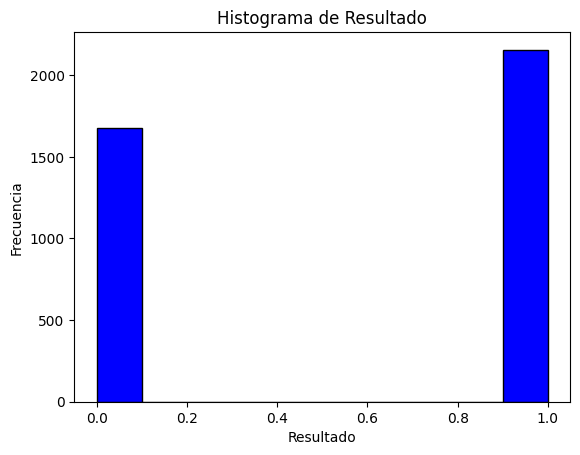

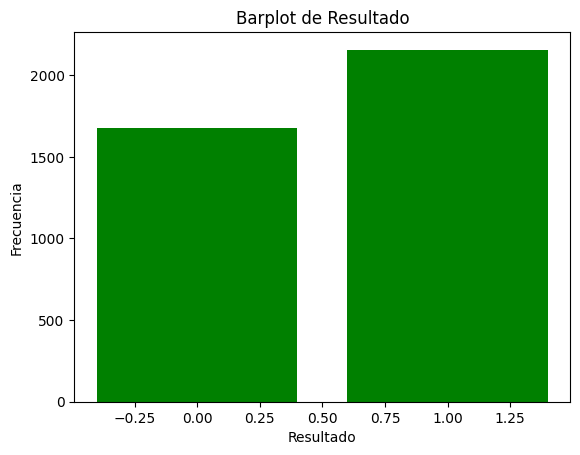

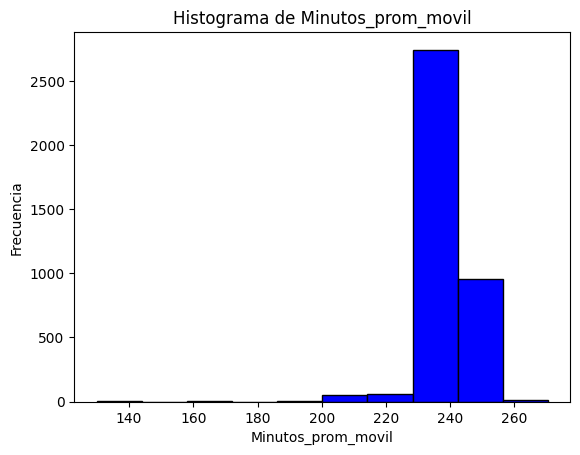

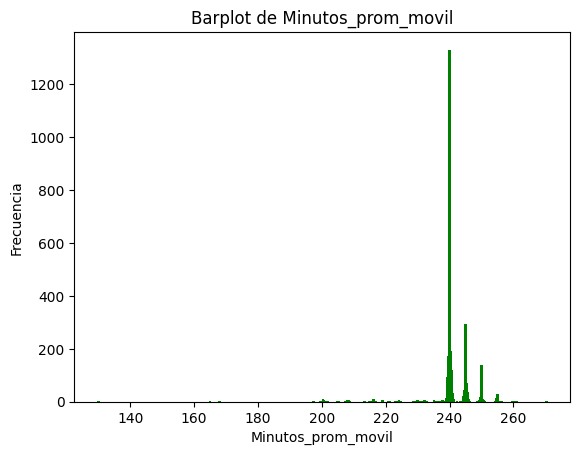

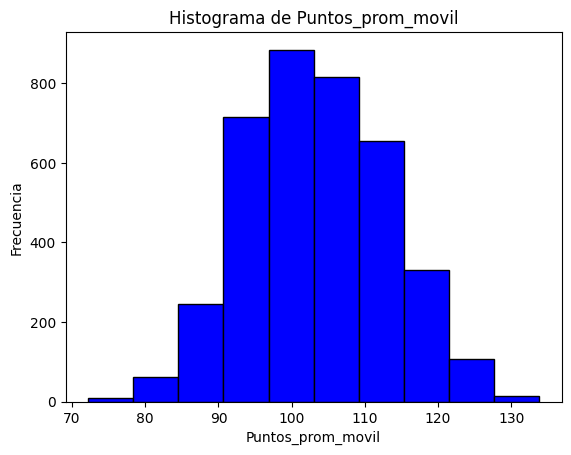

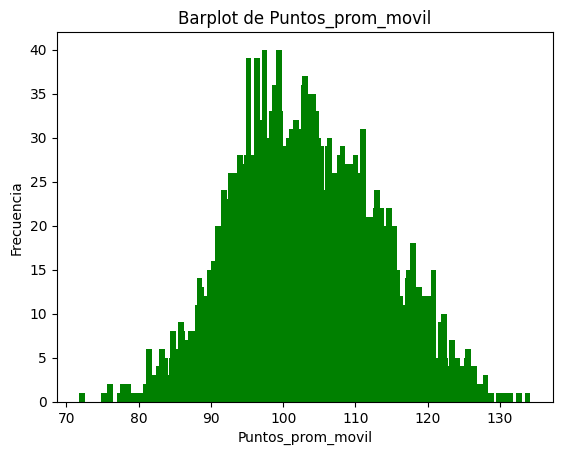

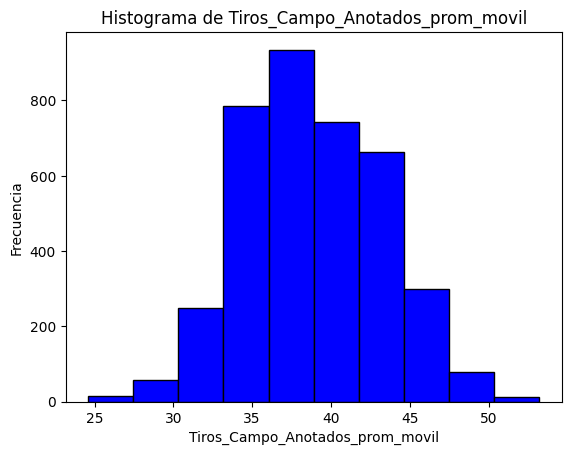

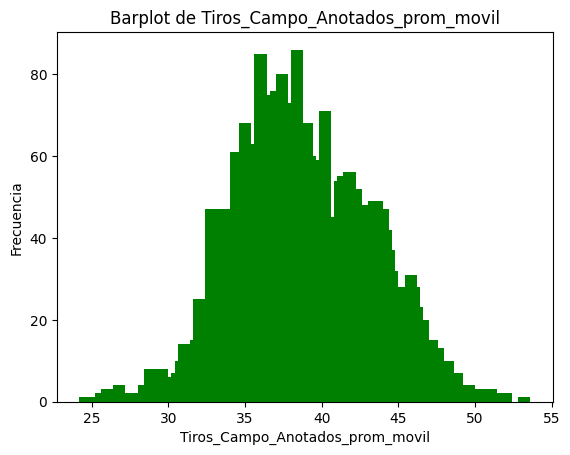

In [55]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt

# Crear sesión de Spark
spark = SparkSession.builder \
    .appName("Análisis Estadístico") \
    .getOrCreate()


columns = ["Fecha_Juego", "Encuentro", "Resultado", "Minutos_prom_movil", "Puntos_prom_movil", "Tiros_Campo_Anotados_prom_movil"]
#df = spark.createDataFrame(data, columns)

# Convertir columna de resultado a entero
df = df.withColumn("Resultado", col("Resultado").cast(IntegerType()))

# Filtrar resultados negativos
df = df.filter(col("Resultado") >= 0)

# Definir función para generar histograma
def generate_histogram(df, column_name, bins=10):
    data = df.select(column_name).rdd.flatMap(lambda x: x).collect()
    plt.hist(data, bins=bins, color='blue', edgecolor='black')
    plt.title(f'Histograma de {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frecuencia')
    plt.show()

# Definir función para generar barplot
def generate_barplot(df, column_name):
    counts = df.groupBy(column_name).count().orderBy(column_name).collect()
    values = [row[column_name] for row in counts]
    counts = [row["count"] for row in counts]
    plt.bar(values, counts, color='green')
    plt.title(f'Barplot de {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frecuencia')
    plt.show()

# Definir lista de columnas para análisis
columnas_analisis = ["Resultado", "Minutos_prom_movil", "Puntos_prom_movil", "Tiros_Campo_Anotados_prom_movil"]

# Ejecutar el pipeline
for columna in columnas_analisis:
    generate_histogram(df, columna)
    generate_barplot(df, columna)

# Cierra la sesión de Spark


Conclusiones

- Las clases estan balanceadas, con 43.48 % igual a 0 y 56.51% igual a 1
- Observamos que el histograma del promedio movil de los minutos por partido presenta asimetria negativa y tiene una curtosis aparentemente leptocurtica
-Observamos que el histograma del promedio movil de los puntos por partido presenta una leve asimetria positiva y tiene una curtosis aparentemente leptocurtica

In [56]:
df.sql_ctx.sparkSession._jsparkSession = spark._jsparkSession
df._sc = spark._sc
# aseguran que el DataFrame df utilice la misma sesión y contexto de Spark que el objeto spark

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Graficas con boxplot de variables numéricas para observar el comportamiento de los datos y si existen valores atipicos.

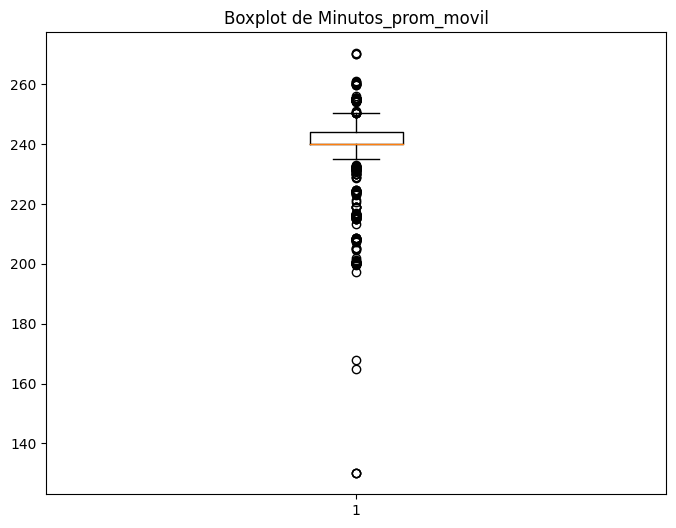

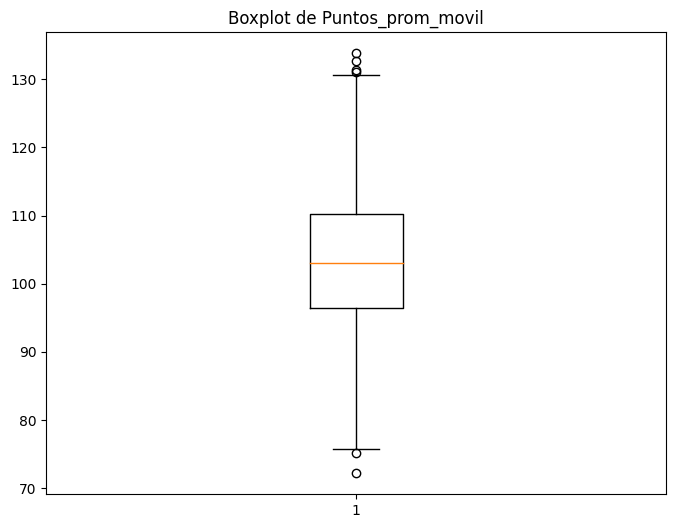

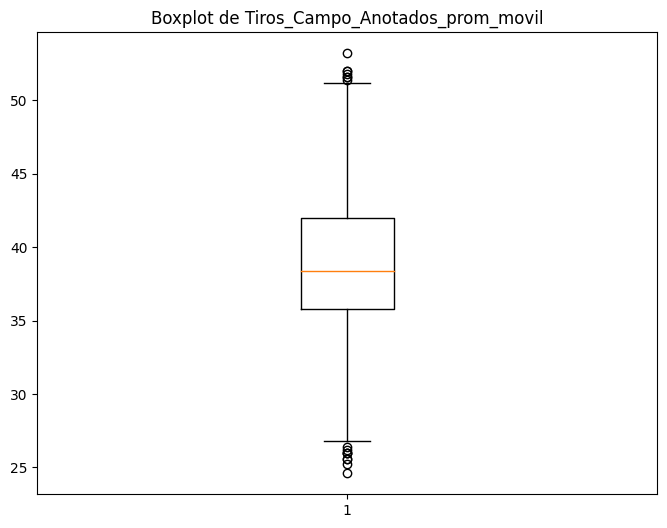

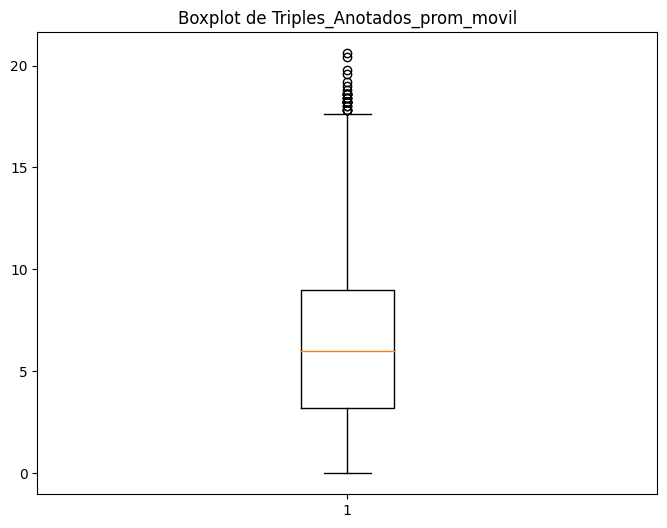

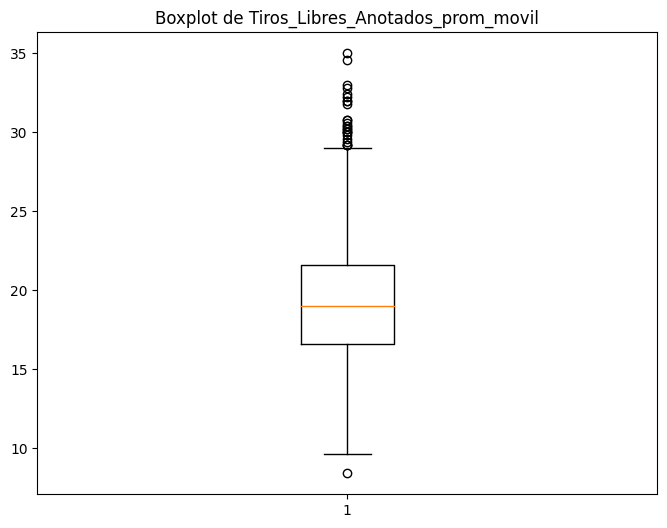

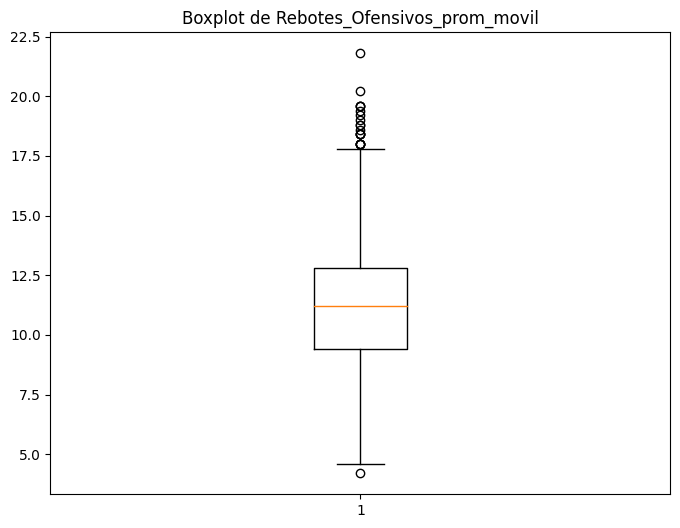

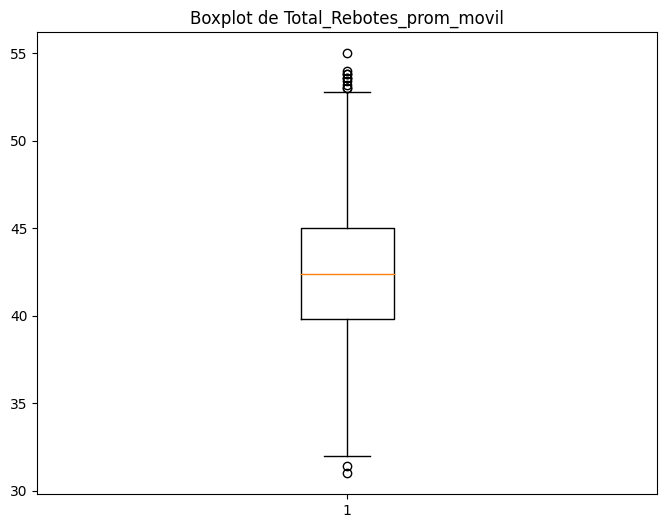

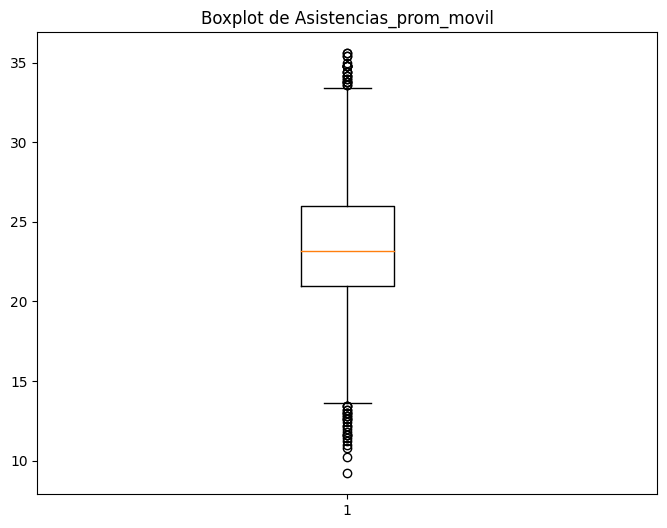

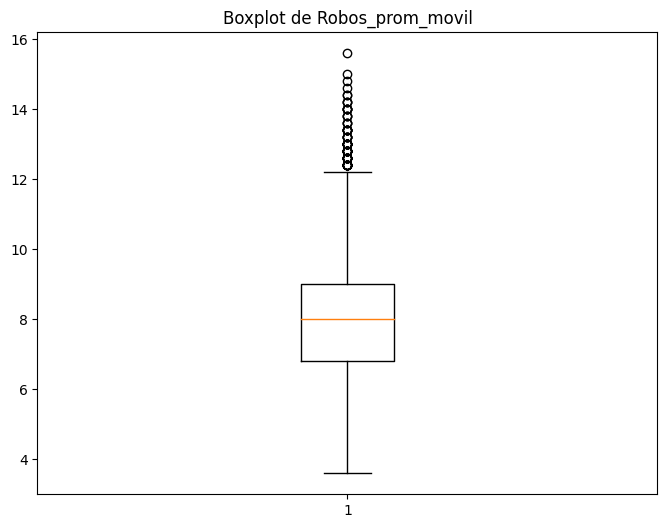

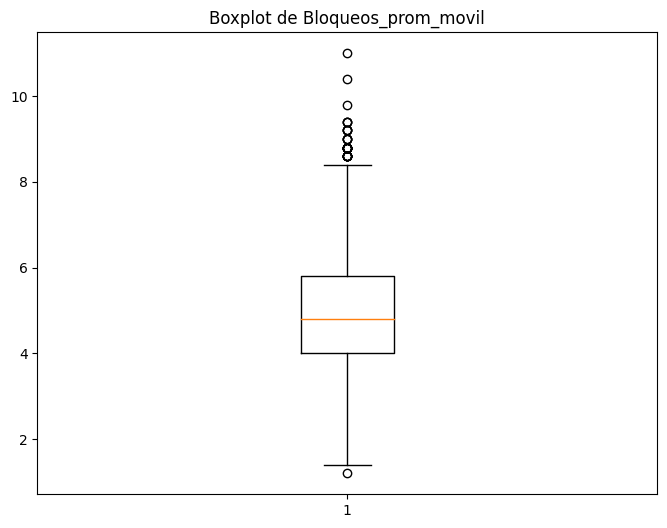

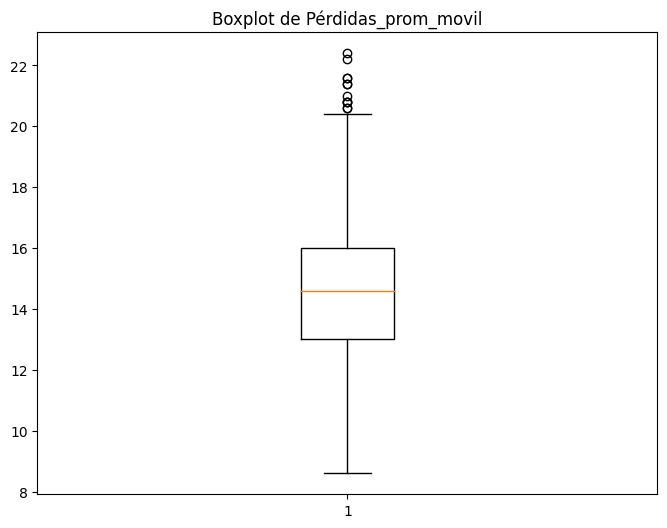

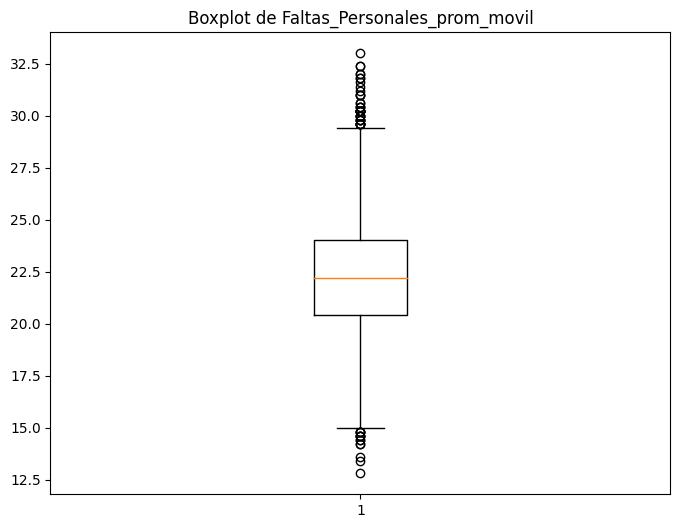

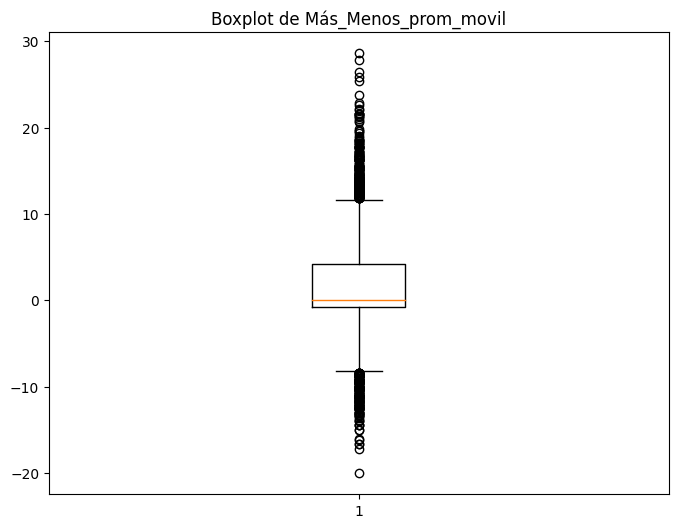

In [57]:

spark = SparkSession.builder \
    .appName("Análisis Estadístico con Boxplot") \
    .getOrCreate()

# Definir las columnas numéricas
columnas_numericas = ["Minutos_prom_movil", "Puntos_prom_movil",
                      "Tiros_Campo_Anotados_prom_movil", "Triples_Anotados_prom_movil",
                      "Tiros_Libres_Anotados_prom_movil", "Rebotes_Ofensivos_prom_movil",
                      "Total_Rebotes_prom_movil", "Asistencias_prom_movil",
                      "Robos_prom_movil", "Bloqueos_prom_movil", "Pérdidas_prom_movil",
                      "Faltas_Personales_prom_movil", "Más_Menos_prom_movil"]

# Realizar análisis estadístico con boxplot para las columnas numéricas
for columna in columnas_numericas:
    # Filtrar valores nulos y convertir a formato pandas
    data = df.select(columna).toPandas()
    plt.figure(figsize=(8, 6))
    plt.boxplot(data[columna])
    plt.title(f'Boxplot de {columna}')
    plt.show()





Observamos que existen varios datos atipicos para las columnas de promedio movil de puntos y minutos por partido. Utilizaremos la tecnica del IQR para su imputacion.

En general, para partidos de la NBA pueden ser considerados como atipicos los siguientes:
- Puntos por encima de 120
- Tiros de campo intentados mayores a 83.44
- Tiros de campo anotados mayores a 40
- Asistencias mayores a 24
- Robos 9, Pérdidas 15, Faltas personales 23.

Detección e imputación de outliers con maximos y mínimos intercuartiles.

In [58]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

class OutlierImputer:
    def __init__(self, df, columns=None):

        self.df = df
        if columns is None:
            # Si no se especifican columnas, se aplicará a todas las columnas numéricas
            self.columns = [column for column in df.columns if df.schema[column].dataType in {'DoubleType', 'IntegerType'}]
        else:
            self.columns = columns

    def detect_outliers_iqr(self):
        outliers = {}
        for columna in self.columns:
            quantiles = self.df.approxQuantile(columna, [0.25, 0.75], 0.05)
            Q1 = quantiles[0]
            Q3 = quantiles[1]
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            column_outliers = self.df.filter((col(columna) < lower_bound) | (col(columna) > upper_bound)).select(columna)
            outliers[columna] = column_outliers

        return outliers

    def impute_outliers_iqr_in_df(self):
        for columna in self.columns:
            quantiles = self.df.approxQuantile(columna, [0.25, 0.85], 0.05)
            Q1 = quantiles[0]
            Q3 = quantiles[1]
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            self.df = self.df.withColumn(columna, \
                                         when(col(columna) < lower_bound, lower_bound) \
                                         .when(col(columna) > upper_bound, upper_bound) \
                                         .otherwise(col(columna)))

# Crear sesión de Spark
spark = SparkSession.builder \
    .appName("Detección de outliers") \
    .getOrCreate()

# Crear instancia de OutlierImputer
outlier_imputer = OutlierImputer(df)

# Detectar outliers
outliers = outlier_imputer.detect_outliers_iqr()
for columna, datos_outliers in outliers.items():
    print(f"Outliers en la columna {columna}:")
    datos_outliers.show()

# Imputar outliers en el DataFrame
outlier_imputer.impute_outliers_iqr_in_df()

df.show()




+-----------+---------+---------+------------------+-----------------+-------------------------------+---------------------------------+---------------------------------+---------------------------+-----------------------------+-----------------------------+--------------------------------+----------------------------------+----------------------------------+----------------------------+-----------------------------+------------------------+----------------------+----------------+-------------------+-------------------+----------------------------+--------------------+
|Fecha_Juego|Encuentro|Resultado|Minutos_prom_movil|Puntos_prom_movil|Tiros_Campo_Anotados_prom_movil|Tiros_Campo_Intentados_prom_movil|Porcentaje_Tiros_Campo_prom_movil|Triples_Anotados_prom_movil|Triples_Intentados_prom_movil|Porcentaje_Triples_prom_movil|Tiros_Libres_Anotados_prom_movil|Tiros_Libres_Intentados_prom_movil|Porcentaje_Tiros_Libres_prom_movil|Rebotes_Ofensivos_prom_movil|Rebotes_Defensivos_prom_movil|Tota

In [59]:
df.describe().show()

+-------+---------+------------------+------------------+-----------------+-------------------------------+---------------------------------+---------------------------------+---------------------------+-----------------------------+-----------------------------+--------------------------------+----------------------------------+----------------------------------+----------------------------+-----------------------------+------------------------+----------------------+------------------+-------------------+-------------------+----------------------------+--------------------+
|summary|Encuentro|         Resultado|Minutos_prom_movil|Puntos_prom_movil|Tiros_Campo_Anotados_prom_movil|Tiros_Campo_Intentados_prom_movil|Porcentaje_Tiros_Campo_prom_movil|Triples_Anotados_prom_movil|Triples_Intentados_prom_movil|Porcentaje_Triples_prom_movil|Tiros_Libres_Anotados_prom_movil|Tiros_Libres_Intentados_prom_movil|Porcentaje_Tiros_Libres_prom_movil|Rebotes_Ofensivos_prom_movil|Rebotes_Defensivos_pro

Se observa que el equipo con el que los Boston Celtics han competido en más ocasiones es el Atlanta Hawks (ATL), mientras que el equipo con el que han tenido el menor número de enfrentamientos es el Washington Wizards (WAS).

Correlación entre variables:


In [60]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

# Seleccionar las columnas numéricas de interés
columnas_numericas = ["Resultado", "Minutos_prom_movil", "Puntos_prom_movil",
                      "Tiros_Campo_Anotados_prom_movil", "Triples_Anotados_prom_movil",
                      "Tiros_Libres_Anotados_prom_movil", "Rebotes_Ofensivos_prom_movil",
                      "Total_Rebotes_prom_movil", "Asistencias_prom_movil",
                      "Robos_prom_movil", "Bloqueos_prom_movil", "Pérdidas_prom_movil",
                      "Faltas_Personales_prom_movil", "Más_Menos_prom_movil"]

# Crear un VectorAssembler para combinar las columnas en un solo vector
assembler = VectorAssembler(inputCols=columnas_numericas, outputCol="features")

# Aplicar el VectorAssembler al DataFrame
df_assembled = assembler.transform(df).select("features")

# Calcular la matriz de correlación
correlation_matrix = Correlation.corr(df_assembled, "features").head()

# Obtener la matriz de correlación
correlation_matrix_array = correlation_matrix[0].toArray()

# Imprimir la matriz de correlación
print("Matriz de correlación:")
print(correlation_matrix_array)



Matriz de correlación:
[[ 1.         -0.00512198  0.11608121  0.10490196  0.01820554  0.03238613
  -0.034119    0.09137015  0.11903236 -0.05557818  0.0817088  -0.02031668
  -0.08283499  0.1133553 ]
 [-0.00512198  1.          0.2553781   0.25768426 -0.00909886  0.06478689
   0.10066611  0.17840011  0.22857055  0.01261206  0.03299983 -0.06719494
   0.04179697 -0.01486056]
 [ 0.11608121  0.2553781   1.          0.88823639  0.17922238  0.28964397
   0.16104607  0.45699375  0.75598617 -0.12542782  0.32700706 -0.11524572
  -0.2190908   0.33756306]
 [ 0.10490196  0.25768426  0.88823639  1.         -0.13248823  0.09536642
   0.28441167  0.43345794  0.82769514 -0.11646131  0.36042495 -0.05110523
  -0.21458744  0.21444676]
 [ 0.01820554 -0.00909886  0.17922238 -0.13248823  1.         -0.39305324
  -0.42033615  0.08355681 -0.07866824 -0.06631863 -0.06545906 -0.39997136
  -0.32396663  0.37439632]
 [ 0.03238613  0.06478689  0.28964397  0.09536642 -0.39305324  1.
   0.23874791  0.06420671  0.0970790

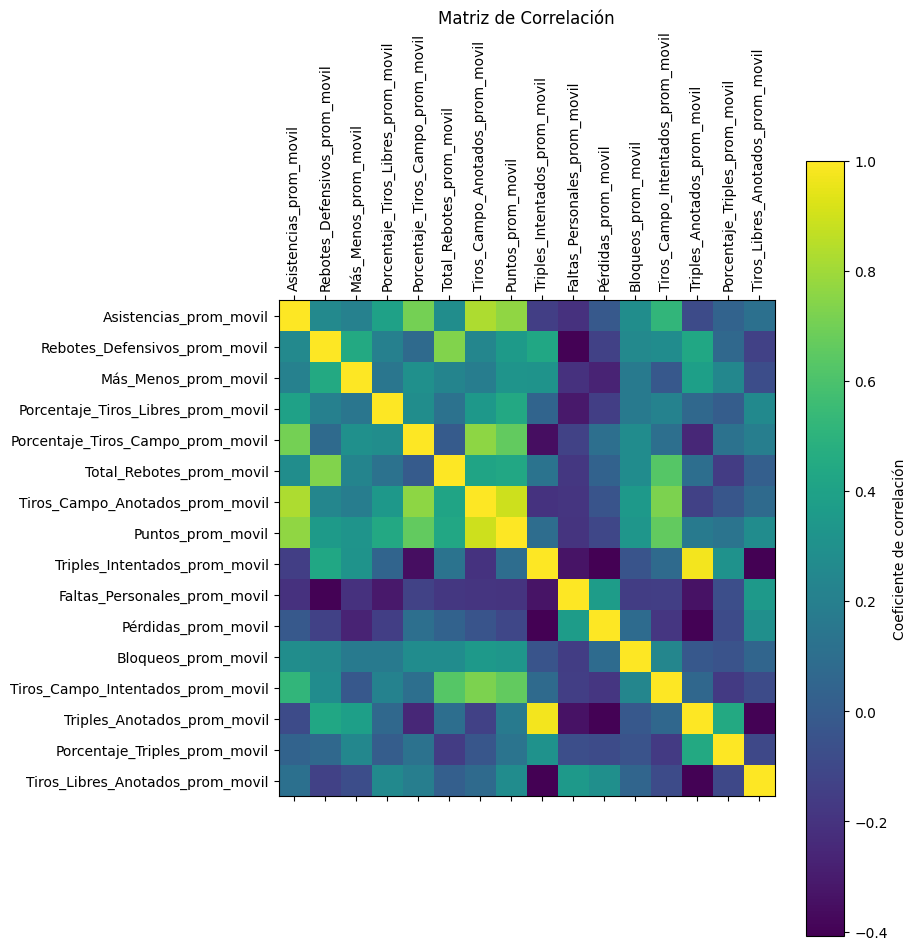

In [61]:
from matplotlib import pyplot as plt
import pandas as pd
from pyspark.sql.functions import rand


numeric_columns = ['Asistencias_prom_movil', 'Rebotes_Defensivos_prom_movil', 'Más_Menos_prom_movil',
                   'Porcentaje_Tiros_Libres_prom_movil', 'Porcentaje_Tiros_Campo_prom_movil',
                   'Total_Rebotes_prom_movil', 'Tiros_Campo_Anotados_prom_movil', 'Puntos_prom_movil',
                   'Triples_Intentados_prom_movil', 'Faltas_Personales_prom_movil', 'Pérdidas_prom_movil',
                   'Bloqueos_prom_movil', 'Tiros_Campo_Intentados_prom_movil', 'Triples_Anotados_prom_movil',
                   'Porcentaje_Triples_prom_movil', 'Tiros_Libres_Anotados_prom_movil']

# Seleccionar una muestra aleatoria de los datos
sample_data = df.select(numeric_columns).orderBy(rand()).limit(1000)

# Convertir los datos de PySpark a Pandas DataFrame
sample_data_df = sample_data.toPandas()

# Graficar la correlación entre las columnas
plt.figure(figsize=(8, 10))
plt.matshow(sample_data_df.corr(), fignum=1)
plt.xticks(range(len(sample_data_df.columns)), sample_data_df.columns, rotation=90)
plt.yticks(range(len(sample_data_df.columns)), sample_data_df.columns)
plt.colorbar(label='Coeficiente de correlación')
plt.title('Matriz de Correlación')
plt.show()


En el heat map anterior se puede observar que hay correlaciones altas entre algunas variables como Tiros libres anotados prom movil vs triples anotados prom movil y triples intentados prom movil.
Pérdidas prom movil vs Triples intentados prom movil.
Porcentajes tiros libres prom movil vs Triples intentados prom Movl.
La VARIABLE Triples intentados prom movil está fuertemente correlacionada con otras variables de este dataset.  

In [62]:
data=df

In [63]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when

In [64]:
df.sql_ctx.sparkSession._jsparkSession = spark._jsparkSession
df._sc = spark._sc

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


# ***One hot enconder***


In [65]:
valores_Encuentro = data.select("Encuentro").distinct().rdd.flatMap(lambda x: x).collect()

# Convertir la columna "Encuentro" en columnas separadas
for valor in valores_Encuentro:
    columna_nueva = "Encuentro_" + valor.lower().replace(" ", "_")
    data = data.withColumn(columna_nueva, when(data["Encuentro"] == valor, 1).otherwise(0))

# Mostrar el DataFrame resultante
data.show()

+-----------+---------+---------+------------------+-----------------+-------------------------------+---------------------------------+---------------------------------+---------------------------+-----------------------------+-----------------------------+--------------------------------+----------------------------------+----------------------------------+----------------------------+-----------------------------+------------------------+----------------------+----------------+-------------------+-------------------+----------------------------+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-----

In [66]:
train_df, test_DF = data.randomSplit([0.8, 0.2], seed=42)

# Mostrar los tamaños de los conjuntos de entrenamiento y prueba
print("Tamaño del conjunto de entrenamiento:", train_df.count())
print("Tamaño del conjunto de prueba:", test_DF.count())

Tamaño del conjunto de entrenamiento: 3121
Tamaño del conjunto de prueba: 714


In [67]:
# Obtener solo los nombres de las columnas del DataFrame df en PySpark
column_names = data.columns

# Mostrar los nombres de las columnas
print(column_names)


['Fecha_Juego', 'Encuentro', 'Resultado', 'Minutos_prom_movil', 'Puntos_prom_movil', 'Tiros_Campo_Anotados_prom_movil', 'Tiros_Campo_Intentados_prom_movil', 'Porcentaje_Tiros_Campo_prom_movil', 'Triples_Anotados_prom_movil', 'Triples_Intentados_prom_movil', 'Porcentaje_Triples_prom_movil', 'Tiros_Libres_Anotados_prom_movil', 'Tiros_Libres_Intentados_prom_movil', 'Porcentaje_Tiros_Libres_prom_movil', 'Rebotes_Ofensivos_prom_movil', 'Rebotes_Defensivos_prom_movil', 'Total_Rebotes_prom_movil', 'Asistencias_prom_movil', 'Robos_prom_movil', 'Bloqueos_prom_movil', 'Pérdidas_prom_movil', 'Faltas_Personales_prom_movil', 'Más_Menos_prom_movil', 'Encuentro_gsw', 'Encuentro_lal', 'Encuentro_det', 'Encuentro_nyk', 'Encuentro_fbu', 'Encuentro_lac', 'Encuentro_uta', 'Encuentro_noh', 'Encuentro_rmd', 'Encuentro_tor', 'Encuentro_mln', 'Encuentro_sas', 'Encuentro_por', 'Encuentro_den', 'Encuentro_eam', 'Encuentro_nok', 'Encuentro_sea', 'Encuentro_dal', 'Encuentro_cle', 'Encuentro_mia', 'Encuentro_okc',

In [68]:
['Fecha_Juego', 'Encuentro', 'Resultado', 'Minutos_prom_movil', 'Puntos_prom_movil', 'Tiros_Campo_Anotados_prom_movil', 'Tiros_Campo_Intentados_prom_movil', 'Porcentaje_Tiros_Campo_prom_movil', 'Triples_Anotados_prom_movil', 'Triples_Intentados_prom_movil', 'Porcentaje_Triples_prom_movil', 'Tiros_Libres_Anotados_prom_movil', 'Tiros_Libres_Intentados_prom_movil', 'Porcentaje_Tiros_Libres_prom_movil', 'Rebotes_Ofensivos_prom_movil', 'Rebotes_Defensivos_prom_movil', 'Total_Rebotes_prom_movil', 'Asistencias_prom_movil', 'Robos_prom_movil', 'Bloqueos_prom_movil', 'Pérdidas_prom_movil', 'Faltas_Personales_prom_movil', 'Más_Menos_prom_movil', 'Encuentro_gsw', 'Encuentro_lal', 'Encuentro_det', 'Encuentro_nyk', 'Encuentro_fbu', 'Encuentro_lac', 'Encuentro_uta', 'Encuentro_noh', 'Encuentro_rmd', 'Encuentro_tor', 'Encuentro_mln', 'Encuentro_sas', 'Encuentro_por', 'Encuentro_den', 'Encuentro_eam', 'Encuentro_nok', 'Encuentro_sea', 'Encuentro_dal', 'Encuentro_cle', 'Encuentro_mia', 'Encuentro_okc', 'Encuentro_phx', 'Encuentro_min', 'Encuentro_mem', 'Encuentro_sac', 'Encuentro_atl', 'Encuentro_phi', 'Encuentro_was', 'Encuentro_nop', 'Encuentro_njn', 'Encuentro_ind', 'Encuentro_hou', 'Encuentro_cha', 'Encuentro_bkn', 'Encuentro_chn', 'Encuentro_chi', 'Encuentro_orl', 'Encuentro_mil', 'Encuentro_sdc', 'Encuentro_chh', 'Encuentro_van', 'Encuentro_kck', 'Encuentro_uth', 'Encuentro_san', 'Encuentro_phl', 'Encuentro_gos']

['Fecha_Juego',
 'Encuentro',
 'Resultado',
 'Minutos_prom_movil',
 'Puntos_prom_movil',
 'Tiros_Campo_Anotados_prom_movil',
 'Tiros_Campo_Intentados_prom_movil',
 'Porcentaje_Tiros_Campo_prom_movil',
 'Triples_Anotados_prom_movil',
 'Triples_Intentados_prom_movil',
 'Porcentaje_Triples_prom_movil',
 'Tiros_Libres_Anotados_prom_movil',
 'Tiros_Libres_Intentados_prom_movil',
 'Porcentaje_Tiros_Libres_prom_movil',
 'Rebotes_Ofensivos_prom_movil',
 'Rebotes_Defensivos_prom_movil',
 'Total_Rebotes_prom_movil',
 'Asistencias_prom_movil',
 'Robos_prom_movil',
 'Bloqueos_prom_movil',
 'Pérdidas_prom_movil',
 'Faltas_Personales_prom_movil',
 'Más_Menos_prom_movil',
 'Encuentro_gsw',
 'Encuentro_lal',
 'Encuentro_det',
 'Encuentro_nyk',
 'Encuentro_fbu',
 'Encuentro_lac',
 'Encuentro_uta',
 'Encuentro_noh',
 'Encuentro_rmd',
 'Encuentro_tor',
 'Encuentro_mln',
 'Encuentro_sas',
 'Encuentro_por',
 'Encuentro_den',
 'Encuentro_eam',
 'Encuentro_nok',
 'Encuentro_sea',
 'Encuentro_dal',
 'Encuentr

# ***MODELOS***

In [69]:
selected_columns = ['Resultado', 'Minutos_prom_movil', 'Puntos_prom_movil', 'Tiros_Campo_Anotados_prom_movil', 'Tiros_Campo_Intentados_prom_movil', 'Porcentaje_Tiros_Campo_prom_movil', 'Triples_Anotados_prom_movil', 'Triples_Intentados_prom_movil', 'Porcentaje_Triples_prom_movil', 'Tiros_Libres_Anotados_prom_movil', 'Tiros_Libres_Intentados_prom_movil', 'Porcentaje_Tiros_Libres_prom_movil', 'Rebotes_Ofensivos_prom_movil', 'Rebotes_Defensivos_prom_movil', 'Total_Rebotes_prom_movil', 'Asistencias_prom_movil', 'Robos_prom_movil', 'Bloqueos_prom_movil', 'Pérdidas_prom_movil', 'Faltas_Personales_prom_movil', 'Más_Menos_prom_movil', 'Encuentro_gsw', 'Encuentro_lal', 'Encuentro_det', 'Encuentro_nyk', 'Encuentro_fbu', 'Encuentro_lac', 'Encuentro_uta', 'Encuentro_noh', 'Encuentro_rmd', 'Encuentro_tor', 'Encuentro_mln', 'Encuentro_sas', 'Encuentro_por', 'Encuentro_den', 'Encuentro_eam', 'Encuentro_nok', 'Encuentro_sea', 'Encuentro_dal', 'Encuentro_cle', 'Encuentro_mia', 'Encuentro_okc', 'Encuentro_phx', 'Encuentro_min', 'Encuentro_mem', 'Encuentro_sac', 'Encuentro_atl', 'Encuentro_phi', 'Encuentro_was', 'Encuentro_nop', 'Encuentro_njn', 'Encuentro_ind', 'Encuentro_hou', 'Encuentro_cha', 'Encuentro_bkn', 'Encuentro_chn', 'Encuentro_chi', 'Encuentro_orl', 'Encuentro_mil', 'Encuentro_sdc', 'Encuentro_chh', 'Encuentro_van', 'Encuentro_kck', 'Encuentro_uth', 'Encuentro_san', 'Encuentro_phl', 'Encuentro_gos']

In [70]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [71]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Crear un StringIndexer para convertir la columna 'Resultado' a números
indexer = StringIndexer(inputCol='Resultado', outputCol='label')

# Crear un VectorAssembler para combinar las características en una columna 'features'
vector_assembler = VectorAssembler(inputCols=selected_columns[2:], outputCol='features')

# Crear el clasificador de Random Forest
rf_classifier = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=100)

# Crear el pipeline con las etapas definidas
pipeline = Pipeline(stages=[indexer, vector_assembler, rf_classifier])

# Dividir los datos en conjuntos de entrenamiento y prueba
(train_data, test_data) = train_df.randomSplit([0.7, 0.3], seed=42)

# Ajustar el modelo usando el pipeline y los datos de entrenamiento
model = pipeline.fit(train_data)

# Realizar predicciones en el conjunto de prueba
predictions = model.transform(test_data)

# Crear un evaluador de clasificación multiclase
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Calcular la precisión en el conjunto de prueba
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

# Calcular la puntuación F1 en el conjunto de prueba
evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1_score = evaluator_f1.evaluate(predictions)
print(f'F1 Score: {f1_score}')


Accuracy: 0.6056497175141243
F1 Score: 0.5822001145611976


In [72]:
predictions = model.transform(test_DF)

# Crear un evaluador de clasificación multiclase
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Calcular la precisión en el conjunto de prueba
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

# Calcular la puntuación F1 en el conjunto de prueba
evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1_score = evaluator_f1.evaluate(predictions)
print(f'F1 Score: {f1_score}')

Accuracy: 0.6092436974789915
F1 Score: 0.5867031340758267


El resultado del modelo Random Forest no es tan bueno como nos gustaria, utilizaremos un feature importance para elegir las variables mas significativas

**Feature Importance**

                               Feature  Importance
13              Asistencias_prom_movil    0.084014
11       Rebotes_Defensivos_prom_movil    0.069378
18                Más_Menos_prom_movil    0.068602
3    Porcentaje_Tiros_Campo_prom_movil    0.065523
9   Porcentaje_Tiros_Libres_prom_movil    0.060068
..                                 ...         ...
33                       Encuentro_eam    0.000000
27                       Encuentro_rmd    0.000000
29                       Encuentro_mln    0.000000
47                       Encuentro_nop    0.000000
23                       Encuentro_fbu    0.000000

[65 rows x 2 columns]


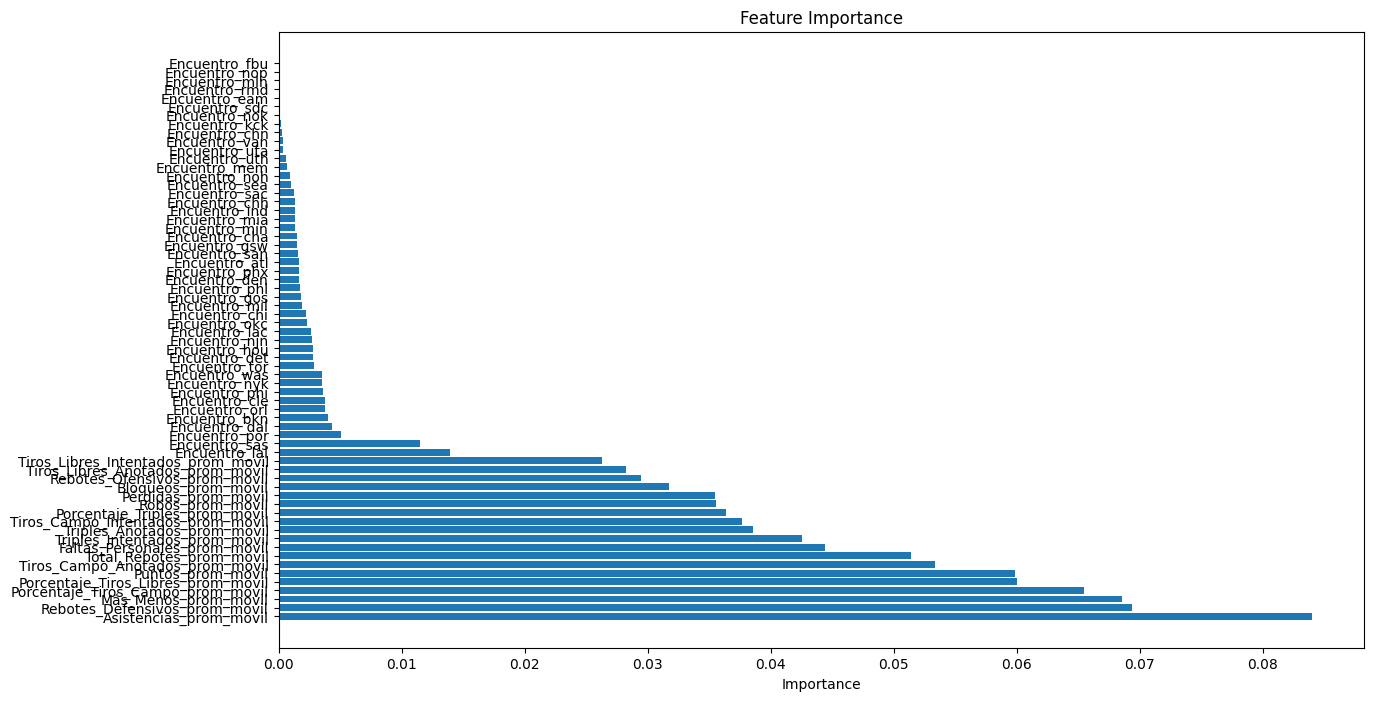

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener las importancias de las características del modelo RandomForest
feature_importances = model.stages[-1].featureImportances

# Obtener el VectorAssembler del pipeline para obtener los nombres de las características
vector_assembler = model.stages[1]
feature_columns = vector_assembler.getInputCols()

# Crear un DataFrame para mostrar las importancias de las características
feature_importance_df = pd.DataFrame(list(zip(feature_columns, feature_importances.toArray())),
                                     columns=['Feature', 'Importance'])

# Ordenar el DataFrame por importancia de características de mayor a menor
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar el DataFrame con las importancias de las características
print(feature_importance_df)

# Crear un gráfico de barras para visualizar las importancias de las características
plt.figure(figsize=(14, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


Características con importancias altas:
                               Feature  Importance
13              Asistencias_prom_movil    0.084014
11       Rebotes_Defensivos_prom_movil    0.069378
18                Más_Menos_prom_movil    0.068602
3    Porcentaje_Tiros_Campo_prom_movil    0.065523
9   Porcentaje_Tiros_Libres_prom_movil    0.060068
0                    Puntos_prom_movil    0.059874
1      Tiros_Campo_Anotados_prom_movil    0.053358
12            Total_Rebotes_prom_movil    0.051393
17        Faltas_Personales_prom_movil    0.044441
5        Triples_Intentados_prom_movil    0.042578
4          Triples_Anotados_prom_movil    0.038556
2    Tiros_Campo_Intentados_prom_movil    0.037704
6        Porcentaje_Triples_prom_movil    0.036375
14                    Robos_prom_movil    0.035549
16                 Pérdidas_prom_movil    0.035510
15                 Bloqueos_prom_movil    0.031752
10        Rebotes_Ofensivos_prom_movil    0.029461
7     Tiros_Libres_Anotados_prom_movil    

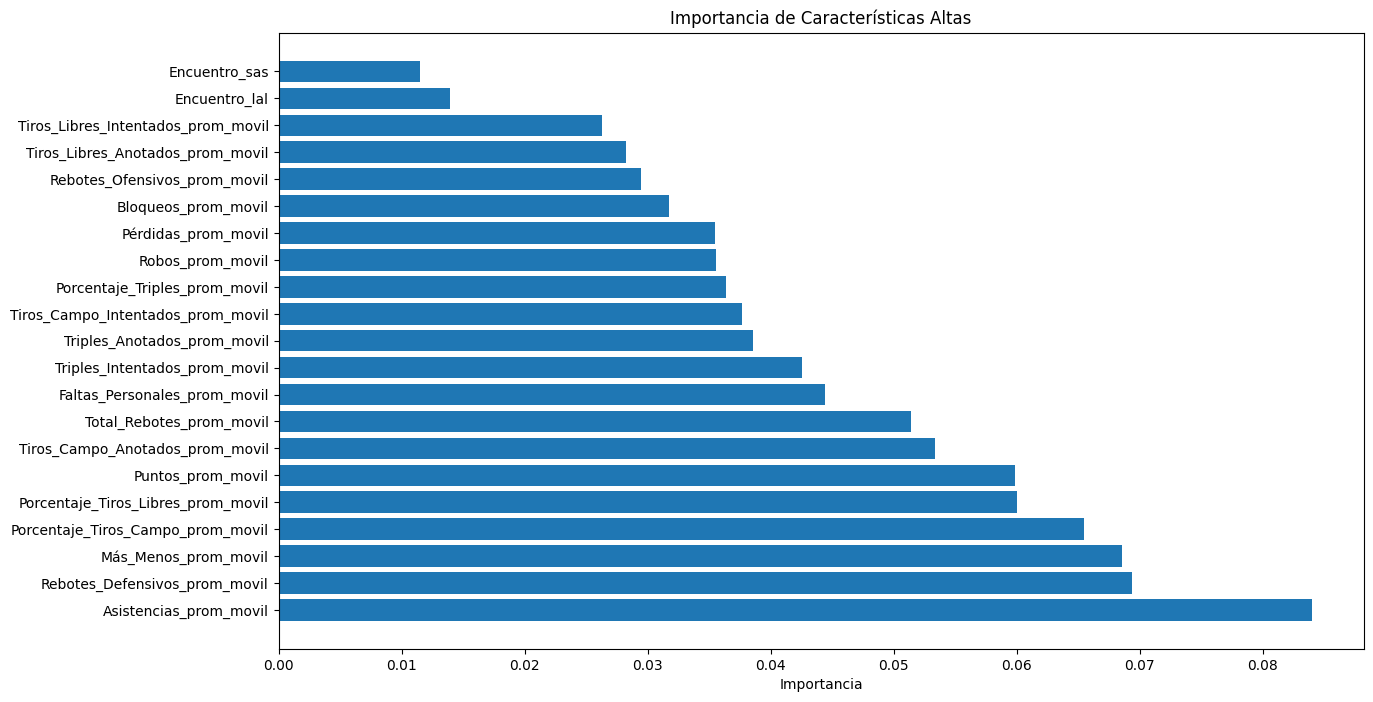

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Umbral para las importancias de características
threshold = 0.01  # Puedes ajustar este valor según tus necesidades

# Filtrar las características con importancias superiores al umbral
high_importance_features = feature_importance_df[feature_importance_df['Importance'] > threshold]

# Mostrar las características con importancias altas
print("Características con importancias altas:")
print(high_importance_features)

# Crear un gráfico de barras para visualizar las importancias de las características altas
plt.figure(figsize=(14, 8))
plt.barh(high_importance_features['Feature'], high_importance_features['Importance'])
plt.xlabel('Importancia')
plt.title('Importancia de Características Altas')
plt.show()


Segun el metodo de features importances, las 5 variables mas signficativas son: Rebotes_Defensivos_prom_movil , Asistencias_prom_movil, Porcentaje_Tiros_Campo_prom_movil, Puntos_prom_movil, Porcentaje_Tiros_Libres_prom_movil

Regresión Logística

In [75]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Crear un StringIndexer para convertir la columna 'Resultado' a números
indexer = StringIndexer(inputCol='Resultado', outputCol='label')

# Crear un VectorAssembler para combinar las características en una columna 'features'
vector_assembler = VectorAssembler(inputCols=selected_columns[2:], outputCol='features')

# Crear el clasificador de Regresión Logística
lr_classifier = LogisticRegression(labelCol='label', featuresCol='features', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Crear el pipeline con las etapas definidas
pipeline = Pipeline(stages=[indexer, vector_assembler, lr_classifier])

# Dividir los datos en conjuntos de entrenamiento y prueba
(train_data, test_data) = train_df.randomSplit([0.7, 0.3], seed=42)

# Ajustar el modelo usando el pipeline y los datos de entrenamiento
model1 = pipeline.fit(train_data)

# Realizar predicciones en el conjunto de prueba
predictions = model1.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Calcular la precisión en el conjunto de prueba
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

# Calcular la puntuación F1 en el conjunto de prueba
evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1_score = evaluator_f1.evaluate(predictions)
print(f'F1 Score: {f1_score}')

Accuracy: 0.5717514124293785
F1 Score: 0.4159686767638613


Optimización Hiperparametros Regresión Logística.

In [76]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


# Crear el evaluador de clasificación multiclase
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Crear el validador cruzado
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=3)  # Puedes ajustar el número de pliegues

# Ajustar el modelo usando la validación cruzada y los datos de entrenamiento
cv_model = cross_validator.fit(train_data)

# Realizar predicciones en el conjunto de prueba
predictions = cv_model.transform(test_data)

# Calcular la precisión en el conjunto de prueba
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

# Calcular la puntuación F1 en el conjunto de prueba
f1_score = evaluator_f1.evaluate(predictions)
print(f'F1 Score: {f1_score}')

# Obtener los mejores parámetros del modelo
best_model = cv_model.bestModel
best_lr_params = best_model.stages[-1].extractParamMap()
print(f'Best Logistic Regression Parameters: {best_lr_params}')


Accuracy: 0.5807909604519774
F1 Score: 0.5455126165953728
Best Logistic Regression Parameters: {Param(parent='LogisticRegression_7093f8ae7e2a', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_7093f8ae7e2a', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_7093f8ae7e2a', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto', Param(parent='LogisticRegression_7093f8ae7e2a', name='featuresCol', doc='features column name.'): 'features', Param(parent='LogisticRegression_7093f8ae7e2a', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_7093f8ae7e2a', name='labelCol', doc='label column name.'): 'label', Param(parent='L

In [77]:
predictions = model1.transform(test_DF)

# Crear un evaluador de clasificación multiclase
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Calcular la precisión en el conjunto de prueba
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

# Calcular la puntuación F1 en el conjunto de prueba
evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1_score = evaluator_f1.evaluate(predictions)
print(f'F1 Score: {f1_score}')

Accuracy: 0.5658263305322129
F1 Score: 0.40893351974063324


La regresion logistica no obtuvo resultados mejores al random forest

In [78]:
!pip install xgboost
!pip install xgboost4j


ERROR: Could not find a version that satisfies the requirement xgboost4j (from versions: none)
ERROR: No matching distribution found for xgboost4j


Linear SVC

In [79]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.sql import SparkSession

# Definir el StringIndexer para la variable de respuesta 'Resultado'
indexer = StringIndexer(inputCol='Resultado', outputCol='label')

# Definir las columnas de características para el VectorAssembler
feature_columns = [col for col in selected_columns if col != 'Resultado']

# Crear un VectorAssembler para combinar las características en una columna 'features'
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Crear el clasificador Linear SVM
svm_classifier = LinearSVC(labelCol='label', featuresCol='features', maxIter=10)

# Crear el pipeline con las etapas definidas
pipeline = Pipeline(stages=[indexer, vector_assembler, svm_classifier])

# Dividir los datos en conjuntos de entrenamiento y prueba
(train_data, test_data) = train_df.randomSplit([0.7, 0.3], seed=42)

# Ajustar el modelo usando el pipeline y los datos de entrenamiento
model = pipeline.fit(train_data)

# Realizar predicciones en el conjunto de prueba
predictions = model.transform(test_data)

# Evaluar el rendimiento del modelo
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

# Calcular la precisión del modelo en el conjunto de prueba
print("Accuracy:", accuracy)
f1_score = evaluator_f1.evaluate(predictions)
print(f'F1 Score: {f1_score}')


Accuracy: 0.576271186440678
F1 Score: 0.551625901985409


Optimización Hiperparametros Linear SVC

In [80]:

# Definir el StringIndexer para la variable de respuesta 'Resultado'
indexer = StringIndexer(inputCol='Resultado', outputCol='label')

# Definir las columnas de características para el VectorAssembler
feature_columns = [col for col in selected_columns if col != 'Resultado']

# Crear un VectorAssembler para combinar las características en una columna 'features'
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Crear el clasificador Linear SVM
svm_classifier = LinearSVC(labelCol='label', featuresCol='features', maxIter=10)

# Crear el pipeline con las etapas definidas
pipeline = Pipeline(stages=[indexer, vector_assembler, svm_classifier])

# Definir la cuadrícula de parámetros
param_grid = (ParamGridBuilder()
               .addGrid(svm_classifier.regParam, [0.1, 0.01, 0.001])
               .addGrid(svm_classifier.maxIter, [10, 20, 30])
               .build())

# Definir el evaluador de clasificación
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Crear el validador cruzado
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=3)  # Puedes ajustar el número de pliegues

# Ajustar el modelo utilizando el validador cruzado y los datos de entrenamiento
cv_model = cross_validator.fit(train_data)

# Realizar predicciones en el conjunto de prueba
predictions = cv_model.transform(test_data)

# Calcular la precisión en el conjunto de prueba
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

# Calcular la puntuación F1 en el conjunto de prueba
f1_score = evaluator_f1.evaluate(predictions)
print(f'F1 Score: {f1_score}')

# Obtener los mejores parámetros del modelo
best_model = cv_model.bestModel
best_svm_params = best_model.stages[-1].extractParamMap()
print(f'Best Linear SVM Parameters: {best_svm_params}')


Accuracy: 0.5751412429378531
F1 Score: 0.5495985453866021
Best Linear SVM Parameters: {Param(parent='LinearSVC_ac0e37f5c839', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LinearSVC_ac0e37f5c839', name='featuresCol', doc='features column name.'): 'features', Param(parent='LinearSVC_ac0e37f5c839', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LinearSVC_ac0e37f5c839', name='labelCol', doc='label column name.'): 'label', Param(parent='LinearSVC_ac0e37f5c839', name='maxBlockSizeInMB', doc='maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0.'): 0.0, Param(parent='LinearSVC_ac0e37f5c839', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LinearSVC_ac0e37f5c839', name='pr

Matriz de confusión:

In [89]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Realizar predicciones en el conjunto de prueba
predictions = cv_model.transform(test_data)

# Calcular la precisión en el conjunto de prueba
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

# Calcular la matriz de confusión
predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)
confusion_matrix = metrics.confusionMatrix()

print("Confusion Matrix:")
print(confusion_matrix)


Accuracy: 0.5751412429378531
Confusion Matrix:
DenseMatrix([[394., 112.],
             [264., 115.]])


La matriz de confusón para este modelo arrojó lo siguiente:
- Verdaderos Positivos (TP): 394
- Falsos Positivos (FP): 112
- Verdaderos Negativos (TN): 115
- Falsos Negativos (FN): 264.
El modelo tiene una precisión moderada.


In [84]:
predictions = model.transform(test_DF)

# Crear un evaluador de clasificación multiclase
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Calcular la precisión en el conjunto de prueba
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

# Calcular la puntuación F1 en el conjunto de prueba
evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1_score = evaluator_f1.evaluate(predictions)
print(f'F1 Score: {f1_score}')

Accuracy: 0.6050420168067226
F1 Score: 0.5786845681104871


El modelo Linear SVC obtuvo resultados similares al random forest, estos 2 han sido los 2 mejores modelelos encontrados en este trabajo.

**Conclusiones finales**

- Desde una perspectiva analítica, es necesario integrar conjuntos de datos adicionales, como las estadísticas individuales de los jugadores y las métricas del equipo adversario, para potenciar la capacidad predictiva de los modelos planteados para este ejercicio. Estos datos complementarios ofrecen una visión más detallada y contextualizada del rendimiento de los equipos y los jugadores, lo que puede mejorar significativamente la metricas de precision y la robustez de nuestras predicciones.
- Se debe realizar un análisis detallado del rendimiento y la escalabilidad de los modelos de ML implementados en PySpark en función del tamaño y la complejidad de los conjuntos de datos. Esto implica evaluar cómo los modelos manejan el aumento del volumen de datos y cómo escalan en términos de tiempo de procesamiento y recursos computacionales.